In [1]:
sentence = " 나는 밥을 먹었다 "

source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
print("Target 문장:", target_sentence)

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


In [2]:
import os, re 
import numpy as np
import tensorflow as tf

# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [5]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

In [6]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fe6d61373d0>


In [7]:
print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


In [8]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


In [9]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


In [10]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [12]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[-6.56533621e-06, -2.98769392e-05, -3.75881471e-04, ...,
         -1.20134595e-04,  1.13174756e-04, -2.16115164e-04],
        [ 4.20975033e-04,  2.71521218e-04, -4.44356090e-04, ...,
         -6.53549912e-04,  1.66025711e-04, -2.83486879e-04],
        [ 4.72840125e-04,  2.53630569e-04, -4.48519393e-04, ...,
         -7.16038805e-04, -1.27936786e-04, -4.02175297e-04],
        ...,
        [-1.69973832e-03,  4.99817310e-03, -3.11300159e-03, ...,
         -2.14466010e-03,  2.54091970e-03, -1.81813631e-03],
        [-1.95481069e-03,  5.58874710e-03, -3.51700955e-03, ...,
         -2.41045165e-03,  2.63944431e-03, -1.85708643e-03],
        [-2.16707378e-03,  6.10611914e-03, -3.87378992e-03, ...,
         -2.65984330e-03,  2.71389144e-03, -1.90038281e-03]],

       [[-6.56533621e-06, -2.98769392e-05, -3.75881471e-04, ...,
         -1.20134595e-04,  1.13174756e-04, -2.16115164e-04],
        [-2.11579201e-04,  7.43773417e-05, -6.

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 68s 706ms/step - loss: 4.4966
Epoch 2/30
93/93 [==============================] - 67s 723ms/step - loss: 2.8795
Epoch 3/30
93/93 [==============================] - 67s 723ms/step - loss: 2.7809
Epoch 4/30
93/93 [==============================] - 67s 721ms/step - loss: 2.6924
Epoch 5/30
93/93 [==============================] - 67s 721ms/step - loss: 2.5935
Epoch 6/30
93/93 [==============================] - 67s 721ms/step - loss: 2.5376
Epoch 7/30
93/93 [==============================] - 67s 722ms/step - loss: 2.4950
Epoch 8/30
93/93 [==============================] - 67s 721ms/step - loss: 2.4521
Epoch 9/30
93/93 [==============================] - 67s 719ms/step - loss: 2.3950
Epoch 10/30
93/93 [==============================] - 67s 719ms/step - loss: 2.3471
Epoch 11/30
93/93 [==============================] - 67s 719ms/step - loss: 2.3093
Epoch 12/30
93/93 [==============================] - 67s 718ms/step - loss: 2.2710
Epoch 13/30
9

In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [16]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [17]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he tears strength strength strength tops information information breed breed breed breed born born born instigation roused roused dictator '

In [28]:
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

In [29]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

In [30]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer

In [32]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
        tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [34]:
txt_file_path = os.getenv('HOME')+'/aiffel//lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you']


In [35]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>',
 '<start> i learned how to get along and so you re back <end>',
 '<start> from outer space <end>',
 '<start> i just walked in to find you <end>',
 '<start> here without that look upon your face i should have changed that fucking lock <end>']

In [36]:
tensor, tokenizer = tokenize(corpus)

[[   2   71  241 ...    0    0    0]
 [   2    5   57 ...    0    0    0]
 [   2    5 1094 ...    0    0    0]
 ...
 [   2   48   16 ...    0    0    0]
 [  25    9 2855 ...  264   19    3]
 [   2    6  180 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fe6f8bbd3d0>


In [37]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <START>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[  2  71 241   5  57 664   3   0   0   0   0   0   0   0]
[ 71 241   5  57 664   3   0   0   0   0   0   0   0   0]


In [38]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=2020)

In [39]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

In [40]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [41]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [42]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 2048
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [43]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[ 3.2617524e-04, -3.1723385e-04, -6.5875694e-04, ...,
         -4.2462838e-04, -2.6549312e-04, -9.7635691e-04],
        [ 5.6083529e-04, -4.5314492e-04, -9.7904261e-04, ...,
         -8.4836729e-04,  1.1798703e-03, -1.7216530e-03],
        [ 1.0628188e-03, -2.7796542e-04, -1.3173108e-03, ...,
         -9.0924848e-04,  2.1677692e-03, -2.4381955e-03],
        ...,
        [ 8.6617647e-03, -5.5194758e-03, -4.5191427e-04, ...,
         -1.1348346e-03,  3.6444340e-03, -1.9156162e-03],
        [ 1.0135183e-02, -6.5527656e-03, -6.2286237e-04, ...,
         -1.0949633e-03,  3.3875366e-03, -1.9985880e-03],
        [ 1.1561222e-02, -7.5026611e-03, -7.5428770e-04, ...,
         -1.0800561e-03,  3.0998315e-03, -2.1314255e-03]],

       [[ 3.2617524e-04, -3.1723385e-04, -6.5875694e-04, ...,
         -4.2462838e-04, -2.6549312e-04, -9.7635691e-04],
        [ 2.3567866e-04, -6.1574072e-04, -1.8643787e-03, ...,
         -4.7687799e-04, -

In [44]:

model.summary()

Model: "text_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  14338048  
_________________________________________________________________
lstm_4 (LSTM)                multiple                  33562624  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lstm_5 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense_2 (Dense)              multiple                  14345049  
Total params: 95,808,345
Trainable params: 95,808,345
Non-trainable params: 0
_________________________________________________________________


In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [46]:
history = model.fit(dataset,
          epochs=7,
          validation_data=val_dataset,
          verbose=1)

Epoch 1/7
549/549 [==============================] - 564s 1s/step - loss: 3.6913 - accuracy: 0.4459 - val_loss: 2.8936 - val_accuracy: 0.5096
Epoch 2/7
549/549 [==============================] - 565s 1s/step - loss: 2.7850 - accuracy: 0.5161 - val_loss: 2.6417 - val_accuracy: 0.5346
Epoch 3/7
549/549 [==============================] - 564s 1s/step - loss: 2.4593 - accuracy: 0.5466 - val_loss: 2.4757 - val_accuracy: 0.5578
Epoch 4/7
549/549 [==============================] - 564s 1s/step - loss: 2.1631 - accuracy: 0.5832 - val_loss: 2.3564 - val_accuracy: 0.5782
Epoch 5/7
549/549 [==============================] - 568s 1s/step - loss: 1.8906 - accuracy: 0.6237 - val_loss: 2.2712 - val_accuracy: 0.5970
Epoch 6/7
549/549 [==============================] - 569s 1s/step - loss: 1.6526 - accuracy: 0.6645 - val_loss: 2.2164 - val_accuracy: 0.6130
Epoch 7/7
549/549 [==============================] - 567s 1s/step - loss: 1.4533 - accuracy: 0.7028 - val_loss: 2.1887 - val_accuracy: 0.6266


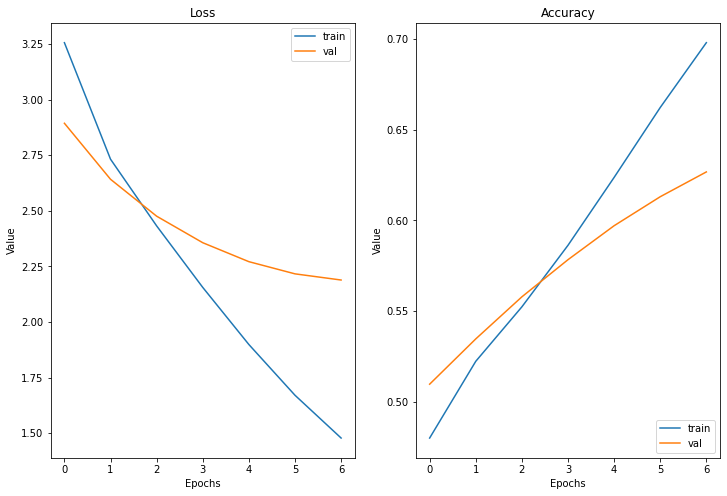

In [47]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [48]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you so much <end> '

In [49]:
generate_text(model, tokenizer, init_sentence="<start> i am", max_len=20)

'<start> i am the generous queen ! ask ms . <unk> <end> '